In [1]:
# import os

# # Setting temp dir to /srv/data directory, as it otherwise fills up the home directory too much
# # Just comment out on machines that are not "Goober"
# os.environ["TMPDIR"] = "/srv/data/tmp"
# os.makedirs("/srv/data/tmp", exist_ok=True)

In [2]:
# %pip install haystack-ai
# %pip install ragas-haystack
# %pip install nltk
# %pip install markdown-it-py
# %pip install mdit_plain
# %pip install openai
# %pip install pandas
# %pip install ragas-haystack
# %pip install sentence-transformers
# %pip install hf_xet
# %pip install ollama-haystack==2.4.2
# %pip install tqdm # For Progress Bar

In [3]:
import os
from datetime import datetime
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from pipelines.evaluation.rag_eval_pipeline import get_rag_evaluation_pipeline
from models import EmbeddingModelConfig, EmbeddingModelProvider, LLMConfig, LLMProvider, RerankingModelConfig, RerankingModelProvider, RewriterModelConfig
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.dataclasses import ChatMessage, Document
from config.prompt import PROMPT_TEMPLATE

In [4]:
from config.secret import OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

os.environ["EMBEDDING_MODEL_NAME"] = "Linq-AI-Research/Linq-Embed-Mistral"
os.environ["SENTENCE_TRANSFORMERS_HOME"] = "./model-assets/sentence-transformers"

In [5]:
test_configs = [
    {
        "name": "Open Source RAG (Top-k=5)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 5,
    },
    {
        "name": "Open Source RAG (Top-k=10)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 10,
    },
    {
        "name": "Open Source RAG (Top-k=20)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 20,
    },
    {
        "name": "Open Source Long Context",
        "embedding_model": None,
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriter_model": None,
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
    },
    {
        "name": "Closed Source RAG (Top-k=5)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
        "retrieval-top-k": 5,
    },
    {
        "name": "Closed Source RAG (Top-k=10)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
        "retrieval-top-k": 10,
    },
    {
        "name": "Closed Source RAG (Top-k=20)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
        "retrieval-top-k": 20,
    },
    {
        "name": "Closed Source Long Context",
        "embedding_model": None,
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriter_model": None,
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
    },
]

In [6]:
import uuid
from typing import List
from haystack.dataclasses import Document
from utils.markdown_utils import for_each_markdown_file

def get_full_documents() -> List[str]:
    full_documents = []
    def add_to_docs_list(filename: str, bytes):
        file_content = bytes.decode("utf-8")
        document = Document(id=str(uuid.uuid4()), content=file_content)
        full_documents.append(document)
    for_each_markdown_file("data/md_files", add_to_docs_list)
    return full_documents

## Generate RAG Responses

In [ ]:
now = datetime.now()
NUMBER_OF_QUESTIONS_IN_EVAL = 10

def run_retrieval_eval(filename, df):
    import re

    match = re.search(r"answers_(.*?)_dataset", filename)
    if match:
        splitting_strategy = match.group(1)
    else:
        splitting_strategy = None

    # 1) Filter out the null‐question rows
    df_nonnull = df[df["question"].notnull()]

    df_shuffled = df_nonnull.sample(n=NUMBER_OF_QUESTIONS_IN_EVAL, random_state=42)
    full_documents = get_full_documents()

    for index, row in tqdm(
        df_shuffled.iterrows(),
        total=len(df_shuffled),
        desc="Processing rows",
        unit="row"
    ):
        question = row["question"]
        reference = row["groundTruth"]
        previous_messages = [
            ChatMessage.from_user(msg) if idx == 0
            else ChatMessage.from_assistant(msg)
            for idx, msg in enumerate(row["prev_messages"])
        ]

        for test_config in test_configs:
            if test_config["embedding_model"] == None:
                pipeline = get_rag_evaluation_pipeline(
                    llm_config=test_config["llm"],
                    base_indexing_store=None,
                    embedding_model_config=None,
                    reranking_model_config=None,
                    rewriting_model_config=None,
                )
                request_payload = {
                    "prompt_builder": {
                        "template": [ChatMessage.from_system(PROMPT_TEMPLATE)] + previous_messages + [ChatMessage.from_user(question)],
                        "documents": full_documents,
                    },
                    "answer_builder": {
                        "query": question,
                    },
                    "evaluator": {
                        "query": question,
                        "reference": reference,
                        "documents": [document.content for document in full_documents],
                        "reference_contexts": [document.content for document in full_documents],
                    }
                }
            else:
                base_indexing_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/context/{test_config['contextualizer_model'].name}/{splitting_strategy}_indexing_store.json")
                pipeline = get_rag_evaluation_pipeline(
                    llm_config=test_config["llm"],
                    base_indexing_store=base_indexing_store,
                    embedding_model_config=test_config["embedding_model"],
                    reranking_model_config=test_config["reranking_model"],
                    rewriting_model_config=test_config["rewriter_model"],
                )
                request_payload = {
                    "retriever": {
                        "top_k": test_config["retrieval-top-k"],
                    },
                    "prompt_builder": {
                        "template": [ChatMessage.from_system(PROMPT_TEMPLATE)] + previous_messages + [ChatMessage.from_user(question)]
                    },
                    "answer_builder": {
                        "query": question,
                    },
                    "evaluator": {
                        "query": question,
                        "reference": reference,
                        "reference_contexts": [document.content for document in row["documents"]]
                    }
                }
                if "reranker" in pipeline.graph.nodes:
                    request_payload["reranker"] = {
                        "query": question,
                    }

                if "rewriter" in pipeline.graph.nodes:
                    request_payload["rewriter"] = {
                        "query": question,
                        "previous_messages": previous_messages,
                    }
                else:
                    request_payload["query_embedder"] = {
                        "text": question,
                    }
            result = pipeline.run(request_payload)

            answer_accuracy = result.get("evaluator", {}).get("result", {})["nv_accuracy"]
            response_relevancy = result.get("evaluator", {}).get("result", {})["answer_relevancy"]
            faithfulness = result.get("evaluator", {}).get("result", {})["faithfulness"]
            df.at[index, f"{test_config['name']}_answer_accuracy"] = answer_accuracy
            df.at[index, f"{test_config['name']}_response_relevancy"] = response_relevancy
            df.at[index, f"{test_config['name']}_faithfulness"] = faithfulness

        save_path = f"results/generation/{now.strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_pickle(save_path)

df = pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_100_20_dataset_flat.pkl")

run_retrieval_eval("question_answers_docs_word_100_20_dataset_flat.pkl", df)

Processing rows:   0%|          | 0/1 [00:00<?, ?row/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 1/1 [13:37<00:00, 817.08s/row]


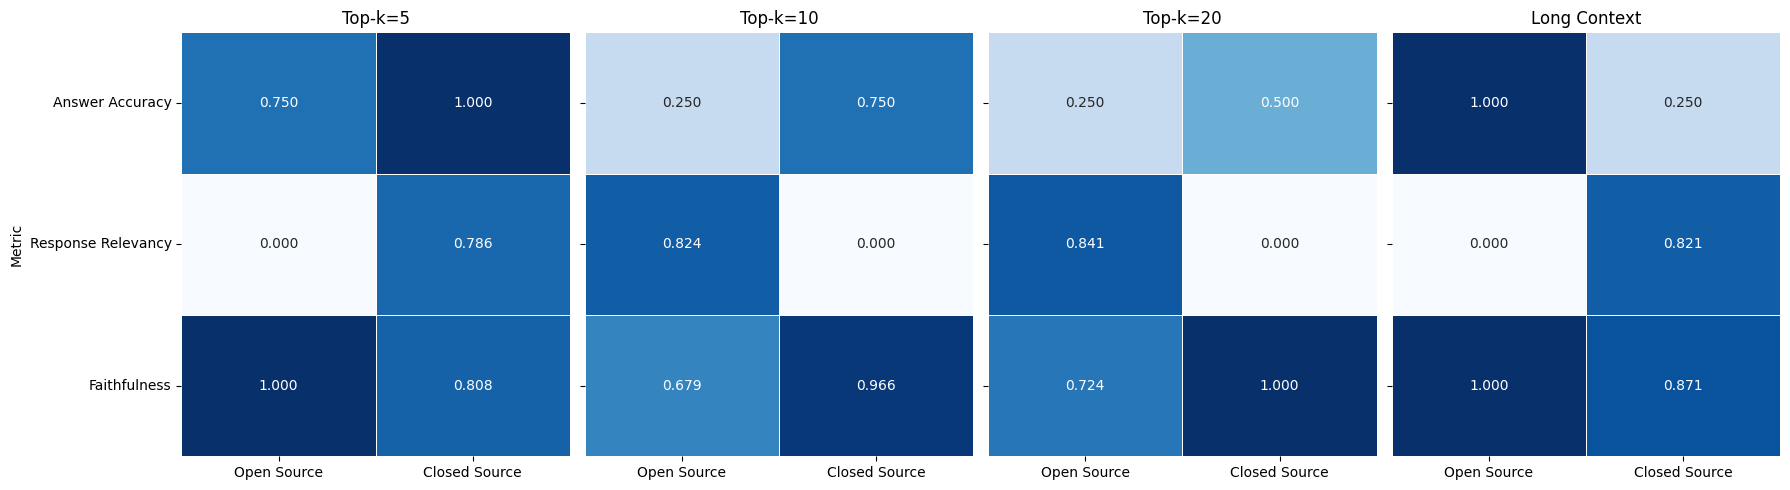

In [13]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle("results/generation/2025-08-14_10-26-20.pkl")

# --- 1) Settings ---
METRICS = [
    "answer_accuracy",
    "response_relevancy",
    "faithfulness",
]
METRIC_LABELS = {
    "answer_accuracy": "Answer Accuracy",
    "response_relevancy": "Response Relevancy",
    "faithfulness": "Faithfulness",
}
CONFIGS = ["Top-k=5", "Top-k=10", "Top-k=20", "Long Context"]
SOURCES = ["Open Source", "Closed Source"]

# --- 2) Flexible regex ---
pat = re.compile(
    r"^(Open|Closed) Source (?:RAG \(Top-k=(\d+)\)|Long Context)_(answer_accuracy|response_relevancy|faithfulness)$",
    re.IGNORECASE
)

parsed = []
for col in df.columns:
    m = pat.match(col.strip())
    if not m:
        continue
    source = f"{m.group(1).title()} Source"
    k = m.group(2)
    config = f"Top-k={k}" if k is not None else "Long Context"
    metric = m.group(3).lower()
    if config in CONFIGS and metric in METRICS and source in SOURCES:
        parsed.append((col, source, config, metric))

parsed_df = pd.DataFrame(parsed, columns=["column", "source", "config", "metric"])

# --- 3) Prepare matrices for each config ---
heatmaps = {}
for config in CONFIGS:
    sub = parsed_df[parsed_df["config"] == config]
    mat = np.full((len(METRICS), len(SOURCES)), np.nan, dtype=float)
    def unwrap_single_element(val):
        """If val is a list/tuple with one element, return that element, else val."""
        if isinstance(val, (list, tuple)) and len(val) == 1:
            return val[0]
        return val

    # --- Inside the loop where we compute mean_val ---
    for _, row in sub.iterrows():
        # Unwrap list values first
        series = df[row["column"]].apply(unwrap_single_element)
        # Convert to numeric
        vals = pd.to_numeric(series, errors="coerce")
        mean_val = vals.mean(skipna=True)
        i = METRICS.index(row["metric"])
        j = SOURCES.index(row["source"])
        mat[i, j] = mean_val
    heatmaps[config] = pd.DataFrame(
        mat,
        index=[METRIC_LABELS[m] for m in METRICS],
        columns=SOURCES
    )

# --- 4) Plot horizontally with Seaborn style ---
fig, axes = plt.subplots(1, len(CONFIGS), figsize=(5*len(CONFIGS), 5), sharey=True)

if len(CONFIGS) == 1:
    axes = [axes]

for ax, config in zip(axes, CONFIGS):
    summary_df = heatmaps[config]
    sns.heatmap(
        summary_df,
        annot=True,
        cmap="Blues",
        fmt=".3f",
        cbar=False,
        linewidths=0.5,
        vmax=1.0,
        ax=ax
    )
    ax.set_title(config)
    if ax != axes[0]:
        ax.set_ylabel("")  # remove repeated ylabel
    else:
        ax.set_ylabel("Metric")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()

In [ ]:
df[pd.notna(df["Open Source RAG (Top-k=5)_answer_correctness"])]

,question,references,groundTruth,source_file,variations_pretty,documents,variant,prev_messages,Open Source RAG (Top-k=5)_answer_correctness,Open Source RAG (Top-k=5)_response_relevancy,...,Closed Source RAG (Top-k=20)_answer_correctness,Closed Source RAG (Top-k=20)_response_relevancy,Closed Source RAG (Top-k=20)_language_quality,Closed Source RAG (Top-k=20)_faithfulness,Closed Source RAG (Top-k=20)_response_groundedness,Closed Source Long Context_answer_correctness,Closed Source Long Context_response_relevancy,Closed Source Long Context_language_quality,Closed Source Long Context_faithfulness,Closed Source Long Context_response_groundedness
55,Wie hoch ist die Erfolgsrate?,[Die Erfolgsaussichten für eine äußere Wendung...,Die Erfolgsaussichten für eine äußere Wendung ...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=716208c1d9b1fa1f627f8233b706bf947...,short,[],0.652353,0.000000,...,0.496189,0.000000,1.0,[1.0],[1.0],0.373610,0.000000,1.0,None,None
81,Und was muss ich speziell dafür noch erledigen...,[Bitte bringen Sie zum Beratungsgespräch unbed...,Zum Beratungsgespräch sollten Sie unbedingt Ih...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=bace8cdf7eb0b5d3ac199599c32a3bb6c...,contextual,"[Ich habe gehört, dass es bei der äußeren Wend...",0.446396,0.000000,...,0.275977,0.000000,1.0,[0.8461538461538461],[1.0],0.501411,0.776451,1.0,None,None
155,Nach Kaiserschnitt was beachten? Wann Arzt?,[Bitte beachten Sie nach der Entlassung aus de...,Nach der Entlassung sollten Sie auf bestimmte ...,Kaiserschnitt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=3ff49487538e477c63d4d26d918152100...,short,[],0.530670,0.937101,...,0.507454,0.000000,1.0,[0.9285714285714286],[1.0],0.489969,0.945706,1.0,None,None
218,Ab wann sollte ich mich zur Gebuhrt in den DRK...,[Die Anmeldung zur Geburt sollte idealerweise ...,Die Anmeldung zur Geburt sollte ab der 32. Sch...,DRK Geburtshilfe Infos.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=d563966cdd8f0bda5159770022be13d52...,mistake,[],0.857332,0.870304,...,0.591897,0.000000,1.0,[1.0],[1.0],0.656240,0.946253,1.0,None,None
264,ambulante Geburt DRK Kliniken Köpenick,[Tipp: Eine ambulante Geburt ist möglich. Dabe...,"Ja, eine ambulante Geburt ist möglich. Sie kön...",DRK Geburtshilfe Infos.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=0c489f094a07228718cc4386b2ab8aeb3...,keyword,[],0.577575,0.921861,...,0.898557,0.897095,1.0,[1.0],[1.0],0.872512,0.897176,1.0,None,None
321,Und wann genau wird das gemacht?,"[Ein Dammschnitt wird nur vorgenommen, wenn er...","Ein Dammschnitt wird nur durchgeführt, wenn er...",Medizinische Maßnahmen rund um die Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=766d1a33028be5bc1fa6c7bc270154d79...,contextual,"[Ich habe gehört, manchmal wird bei der Geburt...",0.760398,0.000000,...,0.595891,0.000000,1.0,[1.0],[1.0],0.481489,0.840714,1.0,None,None
482,"Was muss ich nach der Narkose machen, wenn ich...",[Falls Sie hormonelle Verhütungsmittel verwend...,Die Wirksamkeit hormoneller Verhütungsmittel (...,Narkose.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=8f7f5cd535106bfa4928e064713b0928f...,slang,[],0.461307,0.944790,...,0.384492,0.000000,1.0,[0.4444444444444444],[1.0],0.835190,0.000000,1.0,None,None
598,Welche Risiken gibt es bei der Fruchtblasenspr...,"[Wird die Fruchtblase geöffnet, kann bei länge...",Bei der Fruchtblasensprengung kann es zu einer...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=07f481a343764517c9c913312fb167532...,mistake,[],0.455336,0.945407,...,0.379259,0.922961,1.0,[0.9629629629629629],[1.0],0.528631,0.000000,1.0,None,None
